In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, BertConfig
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import matplotlib.pyplot as plt

c:\Users\timot\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class BERTClassifier(nn.Module):
    def __init__(self, bert_model, num_classes):
        super(BERTClassifier, self).__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        logits = self.fc(pooled_output)
        return logits

In [3]:
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_token_type_ids=False,
            return_attention_mask=True,
            return_tensors="pt",
        )

        input_ids = inputs["input_ids"].squeeze()
        attention_mask = inputs["attention_mask"].squeeze()

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "label": torch.tensor(label, dtype=torch.long),
        }

In [4]:
def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    for batch in dataloader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [5]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids, attention_mask)
            _, preds = torch.max(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    return accuracy

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased")
bert_config = BertConfig.from_pretrained("bert-base-uncased")


In [8]:
newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))


In [9]:
df = pd.DataFrame({'text': newsgroups.data, 'label': newsgroups.target})
df

,text,label
0,\n\nI am sure some bashers of Pens fans are pr...,10
1,My brother is in the market for a high-perform...,3
2,\n\n\n\n\tFinally you said what you dream abou...,17
3,\nThink!\n\nIt's the SCSI card doing the DMA t...,3
4,1) I have an old Jasmine drive which I cann...,4
...,...,...
18841,DN> From: nyeda@cnsvax.uwec.edu (David Nye)\nD...,13
18842,\nNot in isolated ground recepticles (usually ...,12
18843,I just installed a DX2-66 CPU in a clone mothe...,3
18844,\nWouldn't this require a hyper-sphere. In 3-...,1


In [10]:
df_sampled = df.sample(10000, random_state=42)
df_sampled

,text,label
18265,\n\n\n\tThe runner can leave his base at any t...,9
423,"\nWell, it's not an FTP site, but I got an 800...",12
7900,"Hi,\n I was reading through ""The Spacefligh...",14
14785,"I was a graduate student in the early 1980s, a...",18
5217,FREE-ENERGY TECHNOLOGY\n ...,0
...,...,...
15633,Hi Xperts!\n I have a Sparc-1 with very limi...,5
2902,"Some weeks ago, someone posted an article tell...",12
14528,Does anybody know if there are any good 2d-gra...,1
5534,I just entered the market for a Radar Detector...,7


In [11]:
texts = df_sampled["text"].tolist()
labels = df_sampled["label"].tolist()


In [12]:
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)


In [13]:
MAX_LEN = 128
BATCH_SIZE = 32
NUM_CLASSES = len(newsgroups.target_names)
LEARNING_RATE = 2e-5
EPOCHS = 3

In [14]:
train_dataset = TextClassificationDataset(train_texts, train_labels, tokenizer, MAX_LEN)
val_dataset = TextClassificationDataset(val_texts, val_labels, tokenizer, MAX_LEN)


In [15]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)


In [16]:
model = BERTClassifier(bert_model, NUM_CLASSES).to(device)


In [17]:
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()


In [18]:
train_losses = []
val_accuracies = []

In [19]:
for epoch in range(EPOCHS):
    train_loss = train(model, train_dataloader, optimizer, criterion, device)
    val_accuracy = evaluate(model, val_dataloader, criterion, device)
    print(f"Epoch {epoch + 1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
    train_losses.append(train_loss)
    val_accuracies.append(val_accuracy)


Epoch 1/3, Train Loss: 1.9835, Val Accuracy: 0.6370
Epoch 2/3, Train Loss: 1.0359, Val Accuracy: 0.6955
Epoch 3/3, Train Loss: 0.7104, Val Accuracy: 0.7120


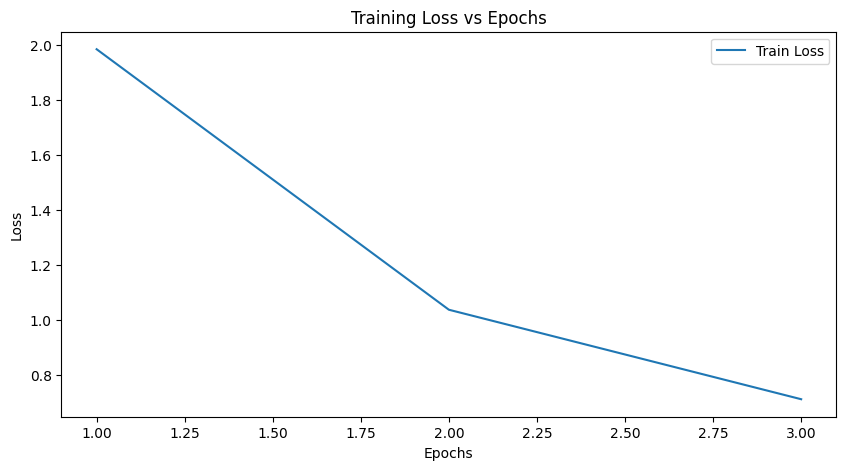

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS + 1), train_losses, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss vs Epochs')
plt.legend()
plt.show()

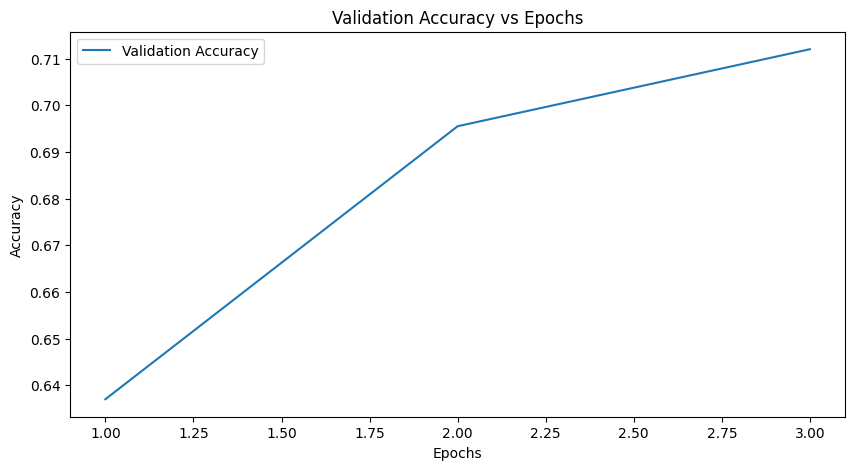

In [21]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy vs Epochs')
plt.legend()
plt.show()

In [22]:
torch.save(model.state_dict(), "bert_classifier_model.pth")

In [23]:
def predict_text(text, model, tokenizer, device):
    model.eval()
    inputs = tokenizer.encode_plus(
        text,
        None,
        add_special_tokens=True,
        max_length=MAX_LEN,
        padding="max_length",
        truncation=True,
        return_token_type_ids=False,
        return_attention_mask=True,
        return_tensors="pt",
    )

    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
        _, preds = torch.max(outputs, dim=1)

    predicted_label = preds.item()
    predicted_class = newsgroups.target_names[predicted_label]
    return predicted_class



In [24]:
model.load_state_dict(torch.load("bert_classifier_model.pth"))
model.eval()

text_to_predict = "He hit a goal and won the match"
predicted_class = predict_text(text_to_predict, model, tokenizer, device)
print("Predicted class:", predicted_class)

Predicted class: rec.sport.hockey
